In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
def create_product_features(df: pd.DataFrame):

    product_metrics = df.groupby('product_id').agg({
        'price': ['mean', 'std'],
        'review_score': ['mean', 'count'],
        'freight_value': 'mean',
        'product_category_name_english': 'first'
    }).round(2)
    
    product_metrics.columns = ['avg_price', 'price_std', 'avg_rating', 
                             'review_count', 'avg_freight', 'category']
    
    product_metrics = product_metrics.fillna({
        'price_std': 0,
        'avg_rating': product_metrics['avg_rating'].mean()
    })
    
    return product_metrics

In [8]:
def calculate_similarity(product_metrics: pd.DataFrame):
    features = ['avg_price', 'avg_rating', 'review_count', 'avg_freight']
    
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(product_metrics[features])
    
    similarity_matrix = cosine_similarity(scaled_features)
    
    return pd.DataFrame(
        similarity_matrix, 
        index=product_metrics.index, 
        columns=product_metrics.index
    )


In [9]:
def get_recommendations(product_id: str, 
                       similarity_matrix: pd.DataFrame,
                       product_metrics: pd.DataFrame,
                       n_recommendations: int = 5):
    if product_id not in similarity_matrix.index:
        return None
    
    similar_scores = similarity_matrix[product_id]
    similar_products = similar_scores.sort_values(ascending=False)[1:n_recommendations+1]
    
    recommendations = product_metrics.loc[similar_products.index]
    recommendations['similarity_score'] = similar_products.values
    
    return recommendations


In [10]:
def visualize_recommendations(original_product: pd.Series, 
                            recommendations: pd.DataFrame):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    prices = [original_product['avg_price']] + recommendations['avg_price'].tolist()
    labels = ['Original'] + [f'Rec {i+1}' for i in range(len(recommendations))]
    
    ax1.bar(labels, prices)
    ax1.set_title('Price Comparison')
    ax1.set_ylabel('Price (BRL)')
    ax1.tick_params(axis='x', rotation=45)
    
    ratings = [original_product['avg_rating']] + recommendations['avg_rating'].tolist()
    
    ax2.bar(labels, ratings)
    ax2.set_title('Rating Comparison')
    ax2.set_ylabel('Average Rating')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    return fig


In [11]:
orders = pd.read_csv(r"olist_orders_dataset.csv")
order_items = pd.read_csv(r"olist_order_items_dataset.csv")
products = pd.read_csv(r"olist_products_dataset.csv")
reviews = pd.read_csv(r"olist_order_reviews_dataset.csv")
categories = pd.read_csv(r"product_category_name_translation.csv")

In [12]:
df = order_items.merge(products, on='product_id')
df = df.merge(reviews[['order_id', 'review_score']], on='order_id')
df = df.merge(categories, on='product_category_name')

In [13]:
product_metrics = create_product_features(df)
similarity_matrix = calculate_similarity(product_metrics)

In [14]:
sample_product_id = product_metrics.index[0]
original_product = product_metrics.loc[sample_product_id]

In [15]:
print("\nOriginal Product:")
print(f"Category: {original_product['category']}")
print(f"Average Price: R${original_product['avg_price']:.2f}")
print(f"Average Rating: {original_product['avg_rating']:.2f}")
print(f"Review Count: {original_product['review_count']}")


Original Product:
Category: perfumery
Average Price: R$101.65
Average Rating: 5.00
Review Count: 1


In [16]:
recommendations = get_recommendations(
    sample_product_id, 
    similarity_matrix, 
    product_metrics
)

print("\nRecommended Products:")
for idx, row in recommendations.iterrows():
    print(f"\nProduct ID: {idx}")
    print(f"Category: {row['category']}")
    print(f"Average Price: R${row['avg_price']:.2f}")
    print(f"Average Rating: {row['avg_rating']:.2f}")
    print(f"Review Count: {row['review_count']}")
    print(f"Similarity Score: {row['similarity_score']:.3f}")


Recommended Products:

Product ID: db7d6b1e3bbc3a8afae8fdee3cca3ee5
Category: construction_tools_construction
Average Price: R$99.97
Average Rating: 5.00
Review Count: 1
Similarity Score: 1.000

Product ID: d934b48db429df3e1f8af7e7368489ee
Category: baby
Average Price: R$99.90
Average Rating: 5.00
Review Count: 1
Similarity Score: 1.000

Product ID: de080af2646decbba6b52a3213110d29
Category: computers_accessories
Average Price: R$99.90
Average Rating: 5.00
Review Count: 1
Similarity Score: 1.000

Product ID: 3560066ba5a5b4f87a8d5de6da565792
Category: health_beauty
Average Price: R$102.99
Average Rating: 5.00
Review Count: 1
Similarity Score: 1.000

Product ID: d4670fa6cc31ee979c4cbd5904e0562a
Category: computers_accessories
Average Price: R$99.00
Average Rating: 5.00
Review Count: 1
Similarity Score: 1.000


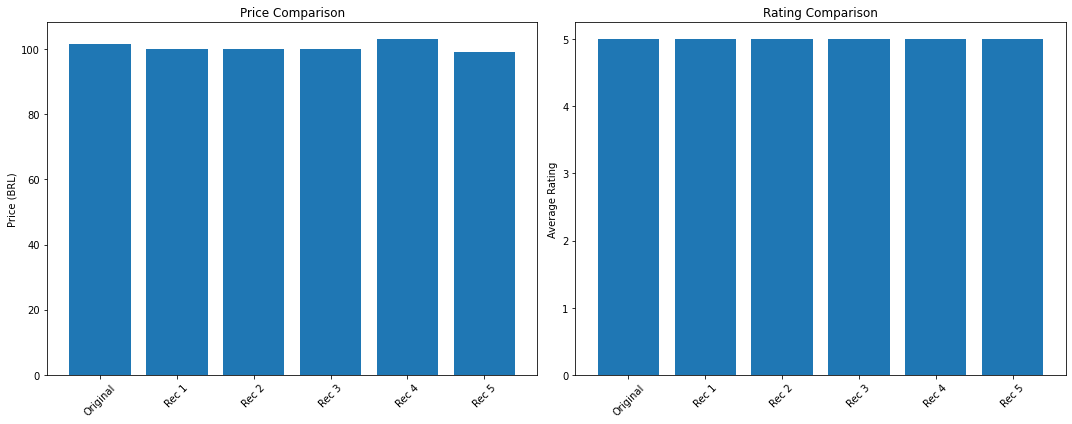

In [17]:
visualize_recommendations(original_product, recommendations)
plt.show()